In [4]:
### distance dependent state transition demo
    
#     In this model the transition probability depends on the distance
#     between the latent locations associated with each discrete state.
#     Specifically, each state k has a location, \ell_k \in R^J, and 
#     the probability of transitioning is 
#         Pr(z_t = k | z_{t-1} = k') 
#              \propto exp(-||\ell_k - \ell_{k'}||/L)   if k \neq k'
#              \propto p_kk                             if k = k'
#     where L is a length scale that we treat as a hyperparameter. 
    
### to-do
### 1. observation: mark
### 2. observation: pseudolikelihood


In [13]:
#### ###############################3
import autograd.numpy as np
import autograd.numpy.random as npr

import matplotlib.pyplot as plt
from scipy.linalg import orthogonal_procrustes, norm
#matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.models import HMM
from ssm.util import find_permutation

# Set the parameters of the HMM
T = 200    # number of time bins
K = 10       # number of discrete states
D = 4       # data dimension
npr.seed(1)

LP: -513.1: 100%|████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 33.51it/s]


Text(0.5,0,'time')

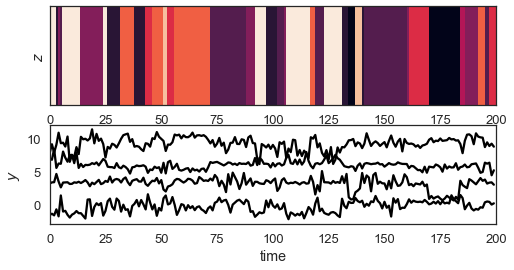

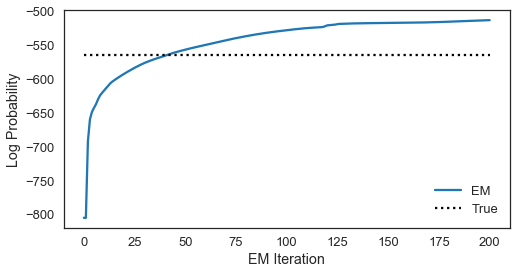

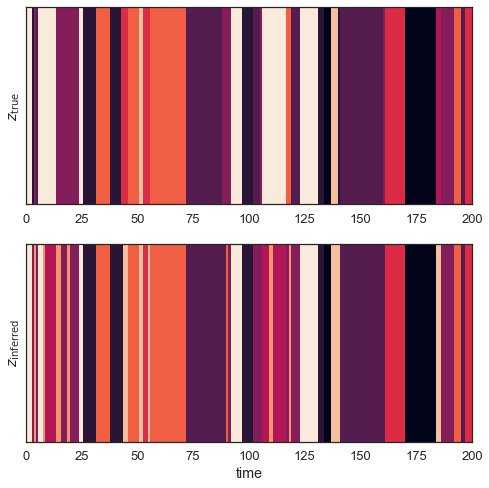

In [6]:
##### #############################################
#### benchmarking I: 
#### 1. generate an HMM with Gaussian observations
#### 2. fit with an dist-HMM
##### #############################################

# Make an HMM
true_hmm = HMM(K, D, observations="gaussian")

# Sample some data from the HMM
z, y = true_hmm.sample(T)
true_ll = true_hmm.log_probability(y)

# Plot it
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto")
plt.xlim(0, 200)
plt.ylabel("$z$")
plt.yticks([])

plt.subplot(212)
plt.plot(y + 3 * np.arange(D), '-k')
plt.xlim(0, 200)
plt.ylabel("$y$")
# plt.yticks([])
plt.xlabel("time")


## ######
# Fit an HMM to this synthetic data
N_iters = 200
hmm = HMM(K, D, transitions="distance", observations="gaussian")
hmm_lls = hmm.fit(y, method="em", num_em_iters=N_iters)

plt.figure(figsize=(8, 4))
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")

# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(y)))
### AssertionError ssm\util\line 41

# Plot the true and inferred discrete states
z_hmm = hmm.most_likely_states(y)

plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto")
plt.xlim(0, 200)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_hmm[None,:], aspect="auto")
plt.xlim(0, 200)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")



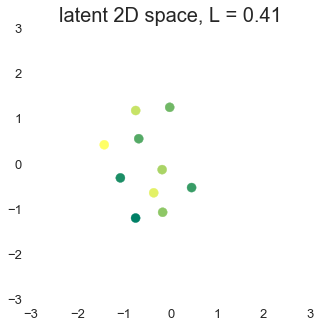

In [7]:
### fitting L
L_hmm = hmm.params[1][0]  # length scale/smoothing
ell_hmm = hmm.params[1][1] # latent 2D space
log_p_hmm = hmm.params[1][2]

prr_hmm = np.exp(log_p_hmm) # diagonal prob
Ps_dist_hmm = np.sum((ell_hmm[:, :, None] - ell_hmm[:, :, None].T) ** 2, axis = 1)
log_P_hmm = -Ps_dist_hmm / L_hmm
log_P_hmm += np.diag(log_p_hmm)
Ps_hmm = np.exp(log_P_hmm)
Ps_hmm /= Ps_hmm.sum(axis=1, keepdims=True)

# Plot it
plt.figure(figsize=(5, 5))
plt.scatter(ell_hmm[:,0], ell_hmm[:,1], c=range(K), cmap="summer")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title("latent 2D space, L = %.2f" % L_hmm, fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
      

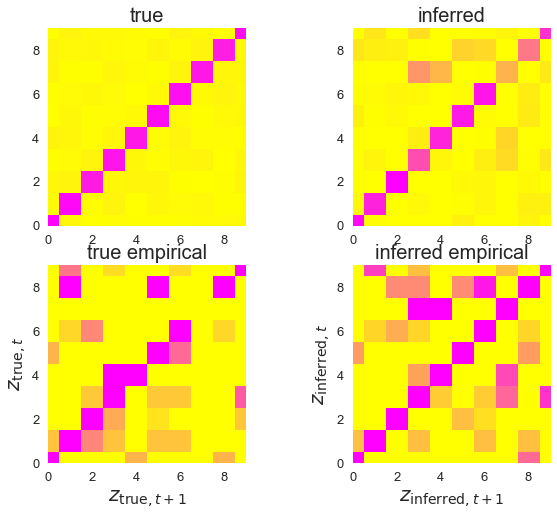

In [8]:
### compare transition matrix
def transition_matrix(transitions):
    n = 1+ max(transitions) #number of states

    A = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        A[i][j] += 1

    #now convert to probabilities:
    for row in A:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return A

A = transition_matrix(z)
A_hmm = transition_matrix(z_hmm)

plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(np.exp(true_hmm.params[1][0]), aspect="equal", cmap="spring_r")
plt.xlim(0,K-1)
plt.ylim(0,K-1)
plt.title("true",fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(222)
plt.imshow(Ps_hmm, aspect="equal", cmap="spring_r")
plt.xlim(0,K-1)
plt.ylim(0,K-1)
plt.title("inferred",fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(223)
plt.title("true empirical",fontsize=20)
plt.imshow(A, aspect="equal", interpolation="none", cmap="spring_r", vmin=0, vmax=0.2)
plt.xlim(0, K-1); plt.ylim(0, K-1)
plt.xlabel("$z_{\\mathrm{true},t+1}$",fontsize=20)
plt.ylabel("$z_{\\mathrm{true},t}$",fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(224)
plt.title("inferred empirical",fontsize=20)
plt.imshow(A_hmm, aspect="equal", interpolation="none", cmap="spring_r", vmin=0, vmax=0.2)
plt.xlim(0, K-1); plt.ylim(0,K-1)
plt.xlabel("$z_{\\mathrm{inferred},t+1}$",fontsize=20)
plt.ylabel("$z_{\\mathrm{inferred},t}$",fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)  

LP: -1052.5: 100%|███████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.71it/s]


Text(0.5,0,'time')

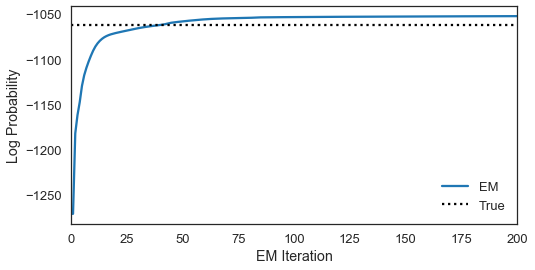

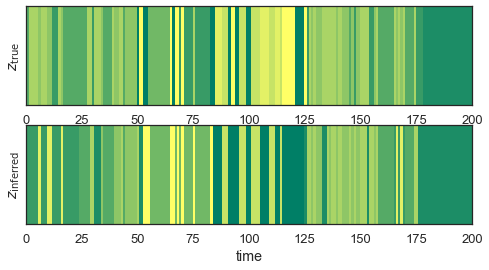

In [9]:
##### #############################################
#### benchmarking II: 
#### 1. generate a dist-HMM with Poisson observations
#### 2. fit with an dist-HMM
##### #############################################

# Make an HMM
npr.seed(2)
true_hmm = HMM(K, D, transitions="distance", observations="poisson")

# Sample some data from the HMM
z, y = true_hmm.sample(T)
true_ll = true_hmm.log_probability(y)

## get L, ell, log_p, Ps
### fitting L
L = true_hmm.params[1][0]  # length scale/smoothing
ell = true_hmm.params[1][1] # latent 2D space
log_p = true_hmm.params[1][2]

### fixed L
#L = 0.1
#ell= true_hmm.params[1][0]
#log_p = true_hmm.params[1][1]

prr = np.exp(log_p) # diagonal prob
Ps_dist = np.sqrt(np.sum((ell[:, :, None] - ell[:, :, None].T) ** 2, axis = 1))
log_P = -Ps_dist / L
log_P += np.diag(log_p)
Ps = np.exp(log_P)
Ps /= Ps.sum(axis=1, keepdims=True)

### ### ### ### ### ###
## ## fit ## ##
### ### ### ### ### ###


# fit an HMM to this synthetic data
N_iters = 200
hmm = HMM(K, D, transitions="distance", observations="poisson")
hmm_lls = hmm.fit(y, method="em", num_em_iters=N_iters)
#hmm_lls = hmm.fit(y)

plt.figure(figsize=(8, 4))
plt.plot(hmm_lls, label="EM")
plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlim(0, N_iters)
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")

# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(y)))
### AssertionError ssm\util\line 41

# Plot the true and inferred discrete states
z_hmm = hmm.most_likely_states(y)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None,:], aspect="auto", cmap="summer")
plt.xlim(0, 200)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_hmm[None,:], aspect="auto", cmap="summer")
plt.xlim(0, 200)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

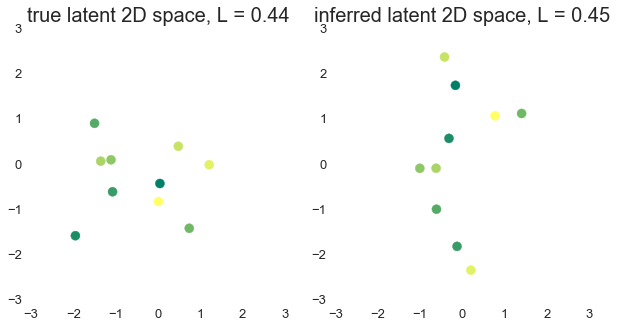

In [10]:
# get L, ell, log_p, Ps
### fitting L
L_hmm = hmm.params[1][0]  # length scale/smoothing
ell_hmm = hmm.params[1][1] # latent 2D space
log_p_hmm = hmm.params[1][2]

### fixed L
#L_hmm = 0.1
#ell_hmm = hmm.params[1][0]
#log_p_hmm = hmm.params[1][1]


prr_hmm = np.exp(log_p_hmm) # diagonal prob
Ps_dist_hmm = np.sum((ell_hmm[:, :, None] - ell_hmm[:, :, None].T) ** 2, axis = 1)
log_P_hmm = -Ps_dist_hmm / L_hmm
log_P_hmm += np.diag(log_p_hmm)
Ps_hmm = np.exp(log_P_hmm)
Ps_hmm /= Ps_hmm.sum(axis=1, keepdims=True)


# Plot it
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(ell[:,0], ell[:,1], c=range(K), cmap="summer")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title("true latent 2D space, L = %.2f" % L, fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(122)
plt.scatter(ell_hmm[:,0], ell_hmm[:,1], c=range(K), cmap="summer")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.title("inferred latent 2D space, L = %.2f" % L_hmm, fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    

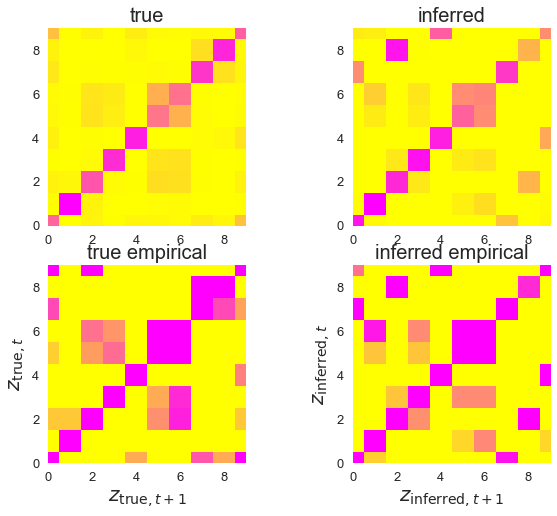

In [11]:
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(Ps, aspect="equal", cmap="spring_r")
plt.xlim(0,K-1)
plt.ylim(0,K-1)
plt.title("true",fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(222)
plt.imshow(Ps_hmm, aspect="equal", cmap="spring_r")
plt.xlim(0,K-1)
plt.ylim(0,K-1)
plt.title("inferred",fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

A = transition_matrix(z)
A_hmm = transition_matrix(z_hmm)

plt.subplot(223)
plt.title("true empirical",fontsize=20)
plt.imshow(A, aspect="equal", interpolation="none", cmap="spring_r", vmin=0, vmax=0.2)
plt.xlim(0, K-1); plt.ylim(0, K-1)
plt.xlabel("$z_{\\mathrm{true},t+1}$",fontsize=20)
plt.ylabel("$z_{\\mathrm{true},t}$",fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(224)
plt.title("inferred empirical",fontsize=20)
plt.imshow(A_hmm, aspect="equal", interpolation="none", cmap="spring_r", vmin=0, vmax=0.2)
plt.xlim(0, K-1); plt.ylim(0,K-1)
plt.xlabel("$z_{\\mathrm{inferred},t+1}$",fontsize=20)
plt.ylabel("$z_{\\mathrm{inferred},t}$",fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

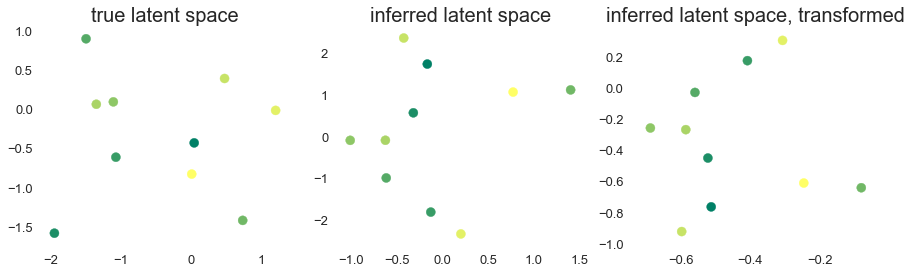

In [15]:
####   ##########################   #####
### align inferred 2D latent space with true 2D latent space
### orthogonal transformation

def orthogonal_transformation(A, B):
    # A: input matrix
    # B: target matrix
    A_mu = A - A.mean(axis=0)
    B_mu = B - B.mean(axis=0)
    R, s = orthogonal_procrustes(A_mu, B_mu)
    scale = s / np.square(norm(A_mu))
    A2 = scale * np.dot(A_mu, R) + B.mean(axis=0)
    
    return A2

ell_hmm_ot = orthogonal_transformation(ell_hmm, ell)

### plot
plt.figure(figsize=(15, 4))

plt.subplot(131)
plt.scatter(ell[:,0], ell[:,1], c=range(K), cmap="summer")
plt.title("true latent space", fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.subplot(132)
plt.scatter(ell_hmm[:,0], ell_hmm[:,1], c=range(K), cmap="summer")
plt.title("inferred latent space", fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
plt.subplot(133)
plt.scatter(ell_hmm_ot[:,0], ell_hmm_ot[:,1], c=range(K), cmap="summer")
plt.title("inferred latent space, transformed", fontsize=20)
for spine in plt.gca().spines.values():
    spine.set_visible(False)